<h1 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 5px 5px;"><strong><centre>Motion Activity Classification Using Recurrent Neural Networks </centre></strong></h1>

<h2 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 5px 5px;"><strong><centre>Methodology: Model Architecture </centre></strong></h2>

#### 03.Model Development
**Objective:** Train a Tradicional RNN model on the preprocessed dataset.

**Model Training:** <br>
<br>
 - **Base Model:**
    + Defines the RNN architecture;
    + Compiles the model with the Adam optimizer and categorical cross-entropy loss;
    + Test adding mores layers to see if the performance gets better
 
 - **Training and Evaluation:**
    + Utilizes EarlyStopping and ModelCheckpoint callbacks for efficient training.
    + Trains the model and evaluates its performance on the validation set.
    + Includes code to visualize training and validation accuracy over epochs.

---

## **Carregamento das Bibliotecas Base**

In [2]:
import os 
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

import time
import pickle

import warnings
warnings.filterwarnings('ignore')

## **Carregamento e Leitura do *Dataset* Pré-processado**

In [19]:
# Definir o caminho do ficheiro relativo ao dataset
file_path = os.path.join(os.getcwd(), 'RNN_dataset', 'concatDataset.csv')

#print(file_path)

+ Utilização do método `read_csv()` para leitura do arquivo CSV com os dados pré-processados

In [4]:
df_motionSense = pd.read_csv(file_path)

+ Visualização das 5 primeiras linhas do *dataset* utilizando o método `head()`

In [5]:
df_motionSense.head(5)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,category_encoded
0,0.972412,1.112051,0.372160,2.329043,-0.814143,0.190001,0.163109,0.417746,0.891213,0.591696,-0.307112,0.677785,0
1,0.972325,1.157371,0.361670,2.365755,-0.865384,0.187932,0.443882,0.221714,0.524710,0.436217,-0.038492,0.186239,0
2,0.972184,1.184141,0.357830,2.387092,-0.896006,0.186328,-0.080028,-0.036082,0.274351,0.006391,0.082024,-0.342729,0
3,0.965350,1.190361,0.360527,2.390690,-0.903162,0.156397,-0.019555,-0.594680,0.017573,-0.032954,0.084569,0.148985,0
4,0.951164,1.192398,0.358982,2.388570,-0.905503,0.094676,0.054879,-0.519408,0.027154,0.395098,0.349372,-0.111607,0


## **Definição de Variáveis Fixas**

In [6]:
NUM_FEATURES = df_motionSense.shape[1] - 1
NUM_CLASSES = df_motionSense['category_encoded'].nunique()
EPOCHS = 50

## **Preparação do *Dataset***

+ A função `prepare_data()` realiza o pré-processamento necessário para treinar um modelo de classificação de atividades baseado em RNNs. Este cria sequências de dados a partir da função `create_sequence()` e divide o conjunto de dados em treino e teste.

Esta divisão foi feita com base na função `train_test_split()` do scikit-learn que permite dividir o conjunto de dados em conjuntos de treino e teste. Este separa as *features* ('x_columns') e a *target* ('y_columns') com um tamanho de conjunto de teste de, neste caso, 20% (`test_size=0.2`), garantindo que os comprimentos dos conjuntos de treino para *features* e *targets* sejam os mesmos.

In [7]:
def prepare_data(df, window_length):
    """
    Preprocesses the dataset for training an RNN-based activity classification model.

    Args:
        df (pandas.DataFrame): The input dataset containing features and labels.
        window_length (int): The desired length of the time window for creating sequences.

    Returns:
        X_train, X_test, y_train, y_test: Processed training and testing data.
    """
    def create_sequences(data, target, window_size):
        sequences = []
        targets = []
        for i in range(len(data) - window_size):
            seq = data[i:i+window_size]
            label = target[i+window_size]
            sequences.append(seq)
            targets.append(label)
        return np.array(sequences), np.array(targets)
    
    y = df['category_encoded']
    X = df.drop(columns=['category_encoded'])
    
    X_seq, y_seq = create_sequences(X, y, window_length)
    
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    
    y_train = to_categorical(y_train, num_classes=y.nunique())
    y_test = to_categorical(y_test, num_classes=y.nunique())
    
    return X_train, X_test, y_train, y_test

## **Definição de Métodos de Regularização**

Os callbacks `EarlyStopping` e `ReduceLROnPlateau` são ferramentas essenciais para otimizar o treino de modelos de Deep Learning no TensorFlow Keras.

+ O `EarlyStopping` interrompe o treino quando uma métrica específica, como a perda de validação (`val_loss`), não mostra melhorias por um número definido de épocas (`patience=10`);    , prevenindo o sobreajuste.

+ O `ReduceLROnPlateau` ajusta dinamicamente a taxa de aprendizagem (`factor=0.2`) do otimizador se a métrica monitorizada (`val_loss`) não apresentar melhorias após um número específico de épocas (`patience=5`), permitindo uma convergência mais suave do modelo.

Usados em conjunto, estes callbacks melhoram a eficiência e a qualidade do treino, bem como ajudam a alcançar um equilíbrio entre o desempenho do modelo e a eficiência computacional.

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

## **Definição da Função de Visualização da Avaliação**

In [9]:
def plot_training_results(history):
    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Training Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Loss")

    plt.tight_layout()
    plt.show()

## **Definição das Arquiteturas com camadas RNN Tradicionais - Multi Layer**

<h2 style="background-color:#C2B4B9; color:white; text-align:center; padding-top:5px; padding-bottom:5px; border-radius: 5px 5px;"><strong><centre>Modelo 4 </centre></strong></h2>

### **Janela Temporal = 20**

2646/2646 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9566 - loss: 0.1539
Test loss: 0.15696902573108673, Test accuracy: 0.9559471607208252


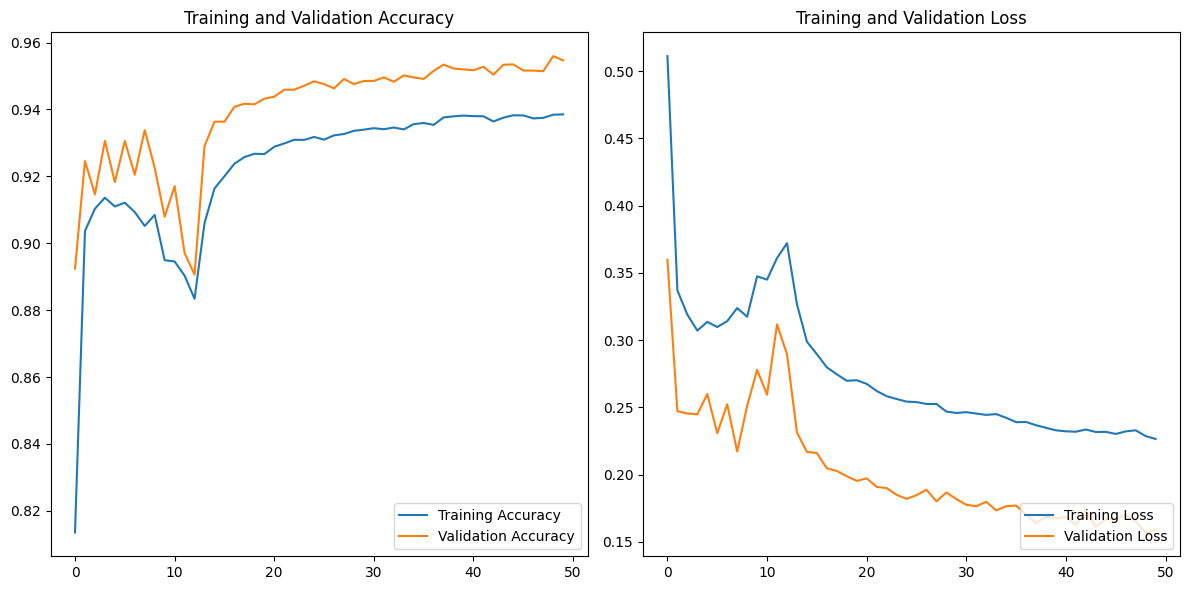

In [11]:
WINDOW_LENGTH = 20
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)


model_4 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_4.summary()

model_4.save('../models/model_4/model_4_h10.keras')

start_time = time.time()

history_10 = model_4.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_4/history_10.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_10.history, file)


loss, accuracy = model_4.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_10)

---

### **Janela Temporal = 30**

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 128)        │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,123 (121.57 KB)

 Trainable params: 31,103 (121.50 KB)

 Non-trainable params: 20 (80.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - accuracy: 0.5777 - loss: 0.8512 - val_accuracy: 0.8457 - val_loss: 0.4060 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 68s 6ms/step - accuracy: 0.8097 - loss: 0.4909 - val_accuracy: 0.8912 - val_loss: 0.3177 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 68s 6ms/step - accuracy: 0.8546 - loss: 0.4197 - val_accuracy: 0.7931 - val_loss: 0.5838 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 69s 6ms/step - accuracy: 0.8749 - loss: 0.3906 - val_accuracy: 0.8965 - val_loss: 0.3165 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 70s 7ms/step - accuracy: 0.8428 - loss: 0.4435 - val_accuracy: 0.8789 - val_loss: 0.3460 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 74s 7ms/step - accuracy: 0.8616 - loss: 0.4094 - val_accuracy: 0.8480 - val_loss: 0.3964 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 70s 7ms/step -

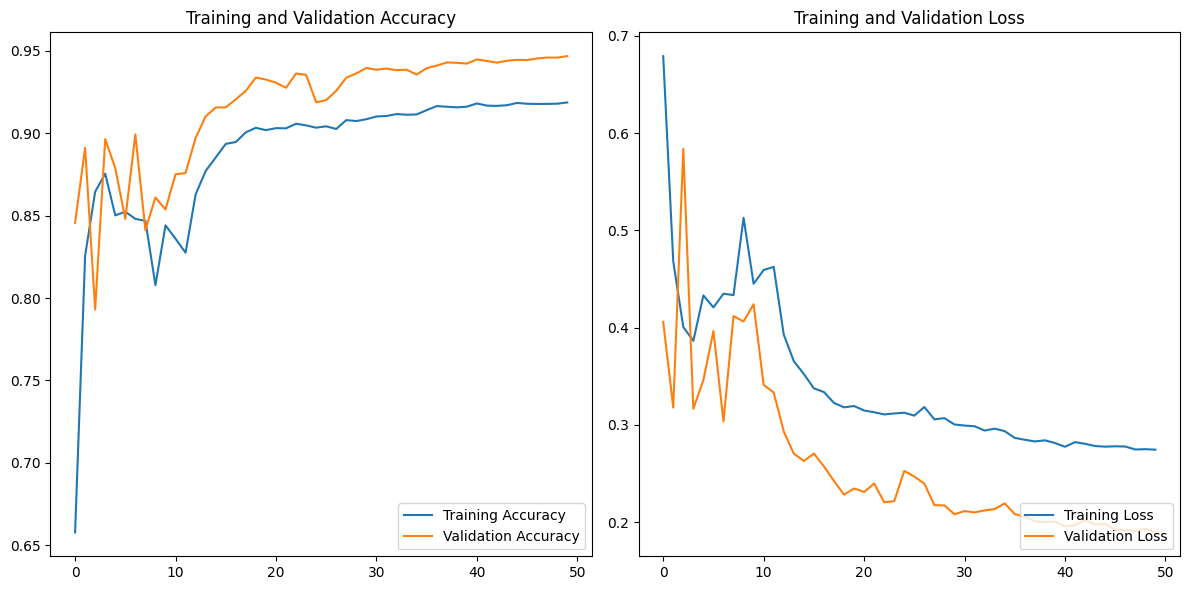

In [10]:
WINDOW_LENGTH = 30
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_4 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_4.summary()

model_4.save('../models/model_4/model_4_h11.keras')

start_time = time.time()

history_11 = model_4.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_4/history_11.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_11.history, file)


loss, accuracy = model_4.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_11)

---

### **Janela Temporal = 50**

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 50, 128)        │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,123 (121.57 KB)

 Trainable params: 31,103 (121.50 KB)

 Non-trainable params: 20 (80.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 105s 10ms/step - accuracy: 0.5123 - loss: 1.0263 - val_accuracy: 0.4097 - val_loss: 1.0793 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 101s 9ms/step - accuracy: 0.4528 - loss: 1.0346 - val_accuracy: 0.6241 - val_loss: 0.7448 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 101s 10ms/step - accuracy: 0.5817 - loss: 0.8380 - val_accuracy: 0.6486 - val_loss: 0.7050 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 101s 10ms/step - accuracy: 0.5245 - loss: 0.9384 - val_accuracy: 0.4052 - val_loss: 1.0889 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 102s 10ms/step - accuracy: 0.4053 - loss: 1.0774 - val_accuracy: 0.6750 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accuracy: 0.5387 - loss: 0.9213 - val_accuracy: 0.6132 - val_loss: 0.8206 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 120

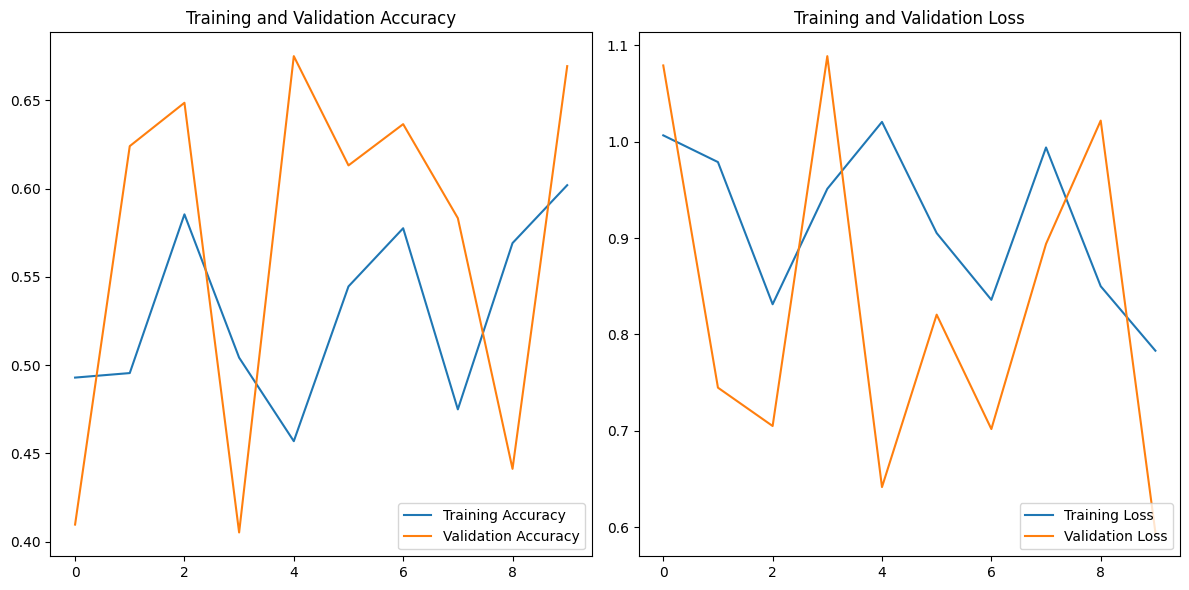

In [11]:
WINDOW_LENGTH = 50
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_4 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_4.summary()

model_4.save('../models/model_4/model_4_h12.keras')

start_time = time.time()

history_12 = model_4.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_4/history_12.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_12.history, file)


loss, accuracy = model_4.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_12)

<h2 style="background-color:#C2B4B9; color:white; text-align:center; padding-top:5px; padding-bottom:5px; border-radius: 5px 5px;"><strong><centre>Modelo 5</centre></strong></h2>

### **Janela Temporal = 20**

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 20, 128)        │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,603 (146.89 KB)

 Trainable params: 37,403 (146.11 KB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 66s 6ms/step - accuracy: 0.5903 - loss: 0.8700 - val_accuracy: 0.7596 - val_loss: 0.5316 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 61s 6ms/step - accuracy: 0.7295 - loss: 0.5998 - val_accuracy: 0.7297 - val_loss: 0.5655 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - accuracy: 0.6868 - loss: 0.6741 - val_accuracy: 0.7098 - val_loss: 0.5983 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 86s 8ms/step - accuracy: 0.7234 - loss: 0.6224 - val_accuracy: 0.6612 - val_loss: 0.6815 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - accuracy: 0.6611 - loss: 0.6984 - val_accuracy: 0.5972 - val_loss: 0.8743 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - accuracy: 0.6440 - loss: 0.7272 - val_accuracy: 0.6998 - val_loss: 0.5893 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 130s 12ms/step

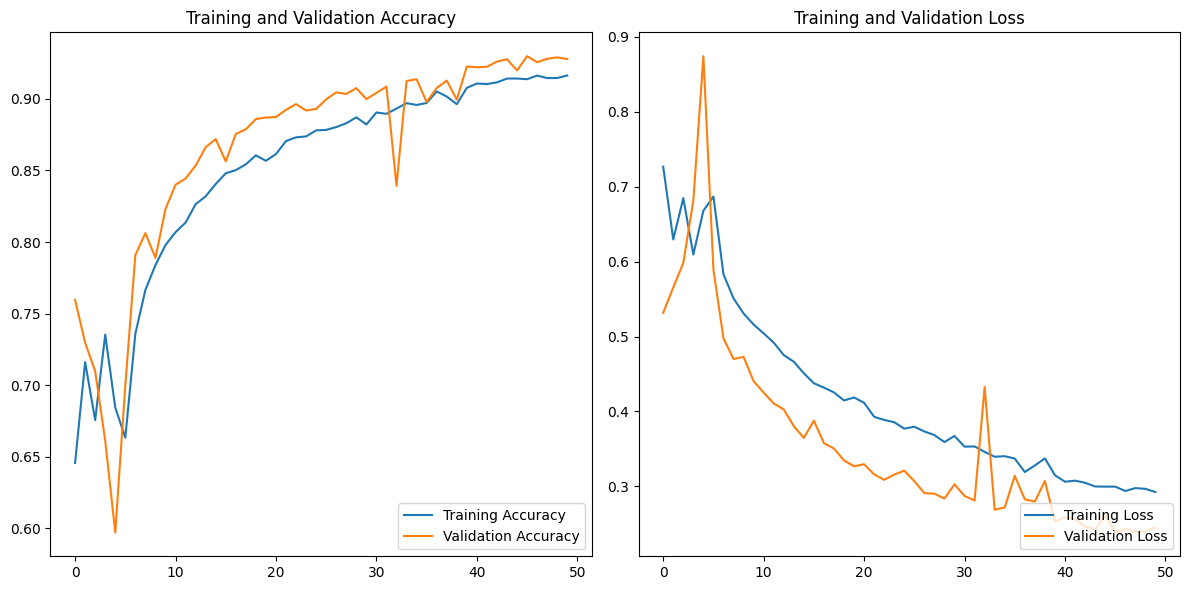

In [20]:
WINDOW_LENGTH = 20
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_5 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])


model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_5.summary()

model_5.save('../models/model_5/model_5_h13.keras')

start_time = time.time()

history_13 = model_5.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_5/history_13.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_13.history, file)


loss, accuracy = model_5.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_13)

---

### **Janela Temporal = 30**

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)        │ (None, 30, 128)        │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,603 (146.89 KB)

 Trainable params: 37,403 (146.11 KB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 111s 10ms/step - accuracy: 0.5449 - loss: 0.9346 - val_accuracy: 0.5596 - val_loss: 0.9049 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 93s 9ms/step - accuracy: 0.4971 - loss: 0.9807 - val_accuracy: 0.6015 - val_loss: 0.8386 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - accuracy: 0.5858 - loss: 0.8675 - val_accuracy: 0.6893 - val_loss: 0.6195 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 94s 9ms/step - accuracy: 0.6730 - loss: 0.6570 - val_accuracy: 0.6990 - val_loss: 0.5694 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 107s 10ms/step - accuracy: 0.6646 - loss: 0.6582 - val_accuracy: 0.6643 - val_loss: 0.5998 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 98s 9ms/step - accuracy: 0.6529 - loss: 0.6531 - val_accuracy: 0.6672 - val_loss: 0.5976 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 93s 9ms/st

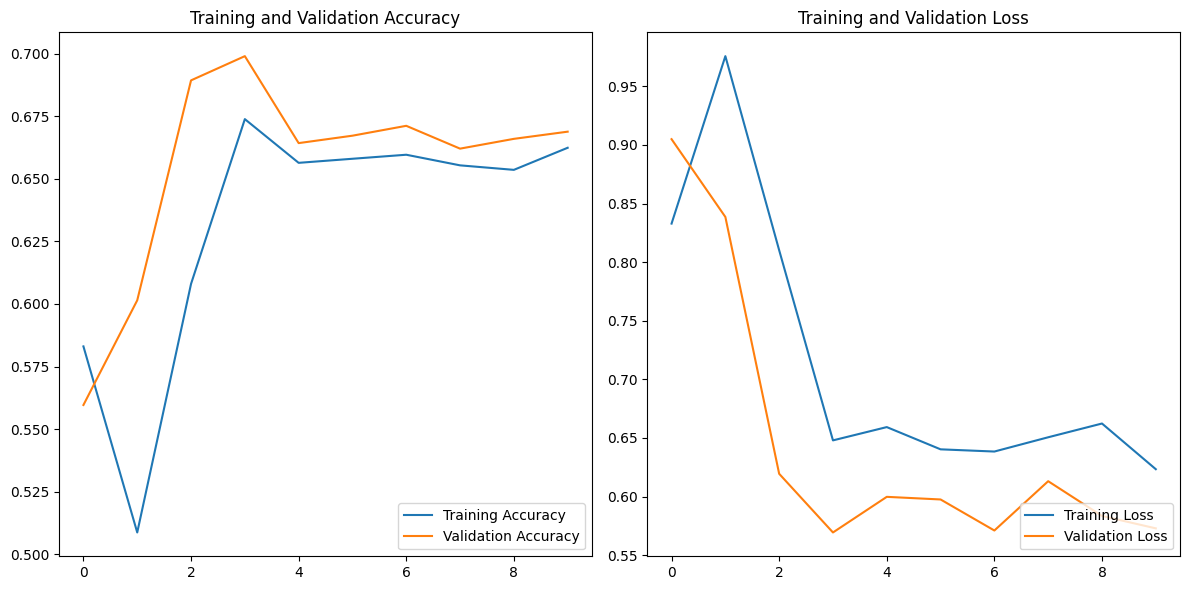

In [21]:
WINDOW_LENGTH = 30
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)


model_5 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_5.summary()

model_5.save('../models/model_5/model_5_h14.keras')

start_time = time.time()

history_14 = model_5.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_5/history_14.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_14.history, file)


loss, accuracy = model_5.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_14)

---

### **Janela Temporal = 50**

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 50, 128)        │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,603 (146.89 KB)

 Trainable params: 37,403 (146.11 KB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accuracy: 0.4793 - loss: 1.0439 - val_accuracy: 0.3715 - val_loss: 1.0916 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accuracy: 0.4170 - loss: 1.0537 - val_accuracy: 0.4725 - val_loss: 1.0232 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 109s 10ms/step - accuracy: 0.4325 - loss: 1.0540 - val_accuracy: 0.3960 - val_loss: 1.0842 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 107s 10ms/step - accuracy: 0.4113 - loss: 1.0696 - val_accuracy: 0.4764 - val_loss: 1.4917 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 109s 10ms/step - accuracy: 0.4581 - loss: 1.0051 - val_accuracy: 0.3173 - val_loss: 1.1354 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 99s 9ms/step - accuracy: 0.4682 - loss: 1.0021 - val_accuracy: 0.3944 - val_loss: 1.0780 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 105s

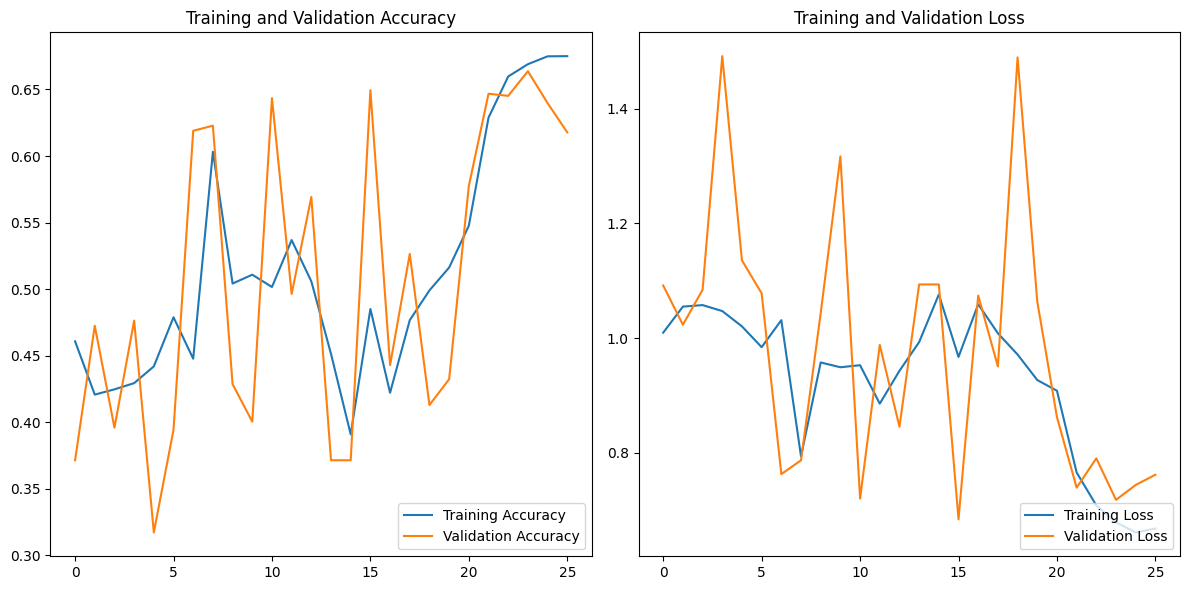

In [21]:
WINDOW_LENGTH = 50
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)


model_5 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_5.summary()

model_5.save('../models/model_5/model_5_h15.keras')

start_time = time.time()

history_15 = model_5.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_5/history_15.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_15.history, file)


loss, accuracy = model_5.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_15)

<h2 style="background-color:#C2B4B9; color:white; text-align:center; padding-top:5px; padding-bottom:5px; border-radius: 5px 5px;"><strong><centre>Modelo 6</centre></strong></h2>

### **Janela Temporal = 20**

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 20, 100)        │        11,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,503 (126.96 KB)

 Trainable params: 32,103 (125.40 KB)

 Non-trainable params: 400 (1.56 KB)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 98s 9ms/step - accuracy: 0.8589 - loss: 0.3882 - val_accuracy: 0.9468 - val_loss: 0.1819 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 94s 9ms/step - accuracy: 0.9287 - loss: 0.2381 - val_accuracy: 0.9446 - val_loss: 0.1868 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 94s 9ms/step - accuracy: 0.9367 - loss: 0.2138 - val_accuracy: 0.9451 - val_loss: 0.1820 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 100s 9ms/step - accuracy: 0.9393 - loss: 0.2082 - val_accuracy: 0.9545 - val_loss: 0.1571 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 95s 9ms/step - accuracy: 0.9409 - loss: 0.2006 - val_accuracy: 0.9381 - val_loss: 0.1993 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - accuracy: 0.9393 - loss: 0.2055 - val_accuracy: 0.9494 - val_loss: 0.1713 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 97s 9ms/step 

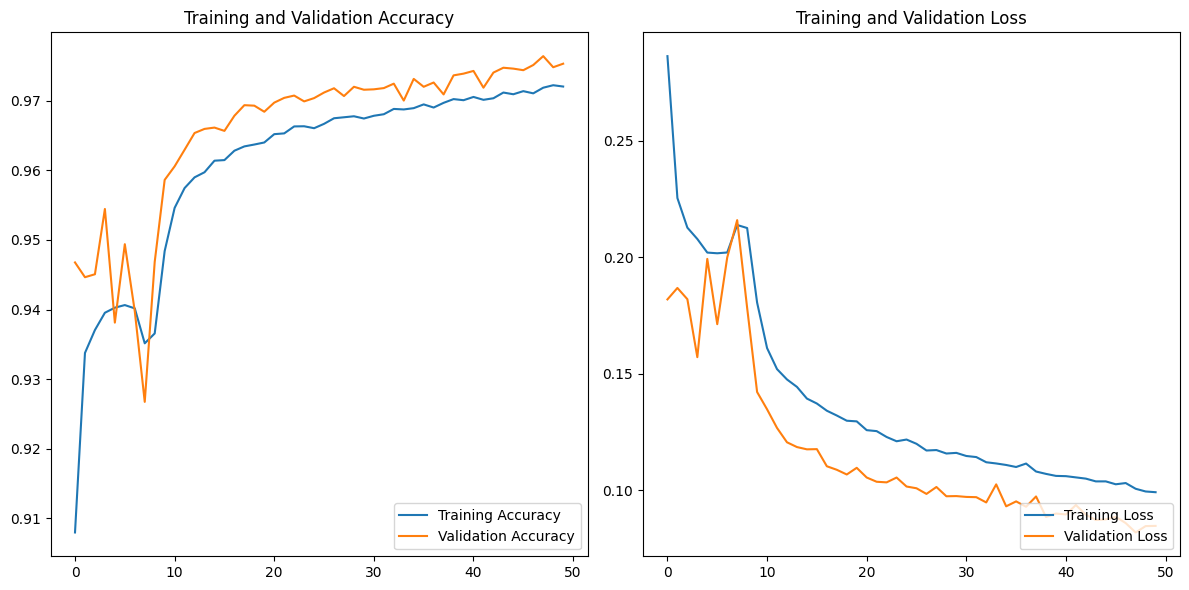

In [22]:
WINDOW_LENGTH = 20

X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

# Crie o modelo
model_6 = Sequential([
    SimpleRNN(100, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    SimpleRNN(100, activation='tanh', return_sequences=False),
    Dropout(0.5),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile o modelo
model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_6.summary()

model_6.save('../models/model_6/model_6_h16.keras')

start_time = time.time()

history_16 = model_6.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_6/history_16.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_16.history, file)


loss, accuracy = model_6.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_16)

---

### **Janela Temporal = 30**

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 100)        │        11,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,503 (126.96 KB)

 Trainable params: 32,103 (125.40 KB)

 Non-trainable params: 400 (1.56 KB)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 119s 11ms/step - accuracy: 0.8086 - loss: 0.4868 - val_accuracy: 0.5286 - val_loss: 1.0927 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 104s 10ms/step - accuracy: 0.7834 - loss: 0.5136 - val_accuracy: 0.8396 - val_loss: 0.4165 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 105s 10ms/step - accuracy: 0.8700 - loss: 0.3657 - val_accuracy: 0.8532 - val_loss: 0.3773 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 114s 11ms/step - accuracy: 0.8723 - loss: 0.3596 - val_accuracy: 0.8960 - val_loss: 0.2985 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accuracy: 0.8691 - loss: 0.3717 - val_accuracy: 0.9198 - val_loss: 0.2591 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 104s 10ms/step - accuracy: 0.8489 - loss: 0.4014 - val_accuracy: 0.7983 - val_loss: 0.4979 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 10

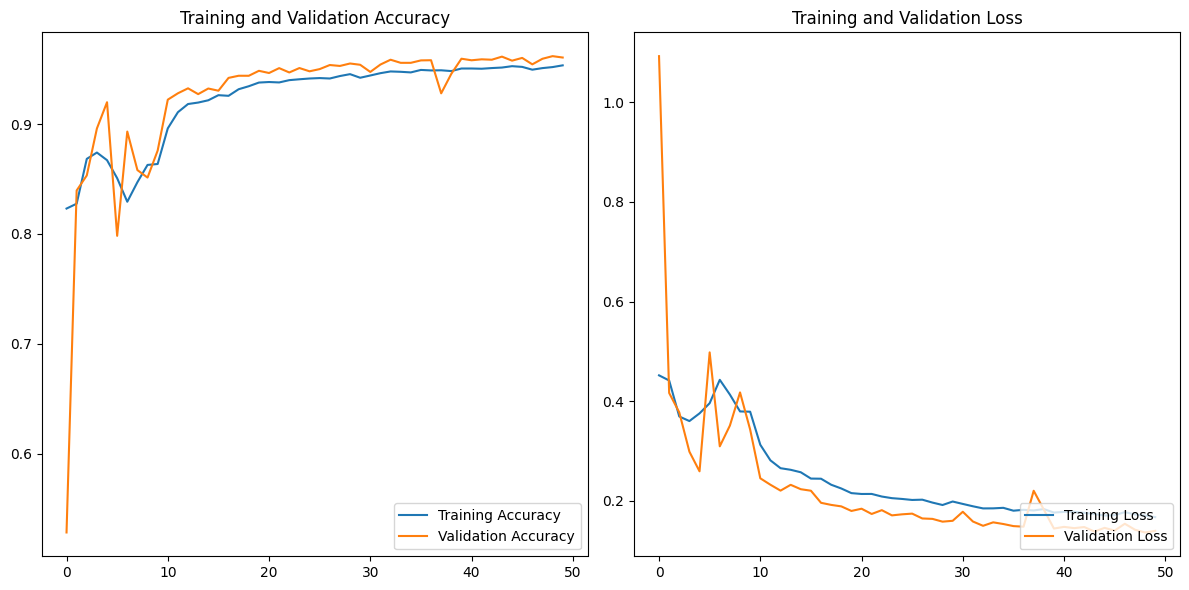

In [10]:
WINDOW_LENGTH = 30

X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

# Crie o modelo
model_6 = Sequential([
    SimpleRNN(100, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    SimpleRNN(100, activation='tanh', return_sequences=False),
    Dropout(0.5),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile o modelo
model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_6.summary()

model_6.save('../models/model_6/model_6_h17.keras')

start_time = time.time()

history_17 = model_6.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_6/history_17.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_17.history, file)


loss, accuracy = model_6.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_17)

---

### **Janela Temporal = 50**

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 50, 100)        │        11,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,503 (126.96 KB)

 Trainable params: 32,103 (125.40 KB)

 Non-trainable params: 400 (1.56 KB)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 147s 14ms/step - accuracy: 0.6268 - loss: 0.7803 - val_accuracy: 0.4725 - val_loss: 1.0187 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 141s 13ms/step - accuracy: 0.3944 - loss: 1.0831 - val_accuracy: 0.5244 - val_loss: 1.0345 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 142s 13ms/step - accuracy: 0.4777 - loss: 0.9856 - val_accuracy: 0.5054 - val_loss: 0.9754 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 145s 14ms/step - accuracy: 0.5921 - loss: 0.7817 - val_accuracy: 0.6143 - val_loss: 0.5668 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 146s 14ms/step - accuracy: 0.6728 - loss: 0.6275 - val_accuracy: 0.7780 - val_loss: 0.4899 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 358s 34ms/step - accuracy: 0.6601 - loss: 0.6563 - val_accuracy: 0.6790 - val_loss: 0.5881 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 15

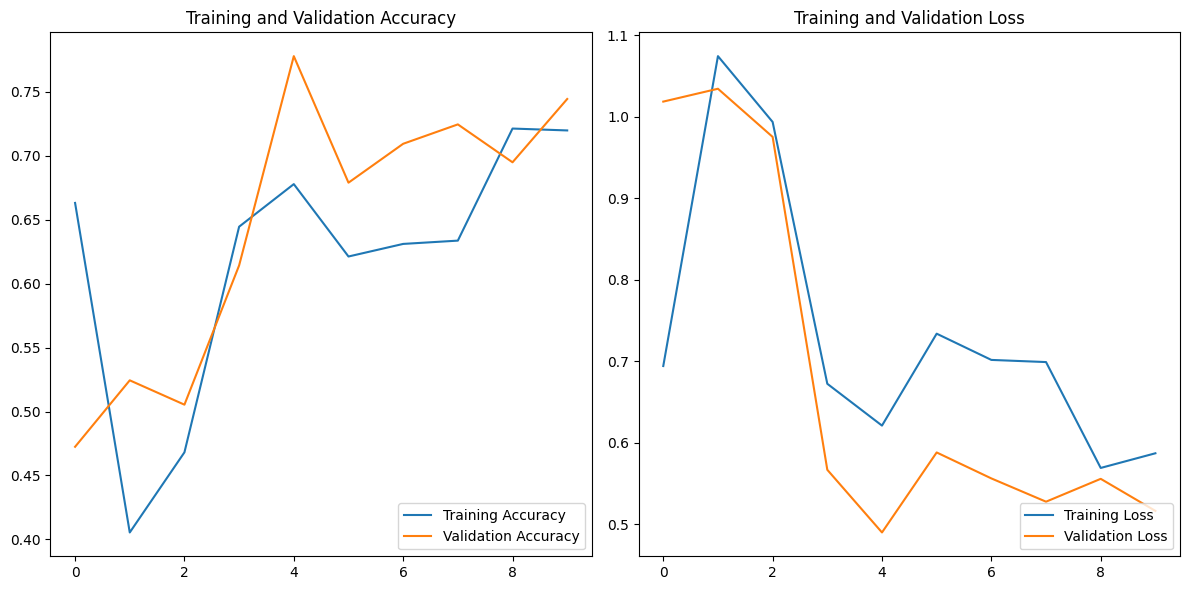

In [11]:
WINDOW_LENGTH = 50

X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

# Crie o modelo
model_6 = Sequential([
    SimpleRNN(100, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    SimpleRNN(100, activation='tanh', return_sequences=False),
    Dropout(0.5),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile o modelo
model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_6.summary()

model_6.save('../models/model_6/model_6_h18.keras')

start_time = time.time()

history_18 = model_6.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_6/history_18.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_18.history, file)


loss, accuracy = model_6.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_18)

---

---

## **Comparação dos Resultados Obtidos**

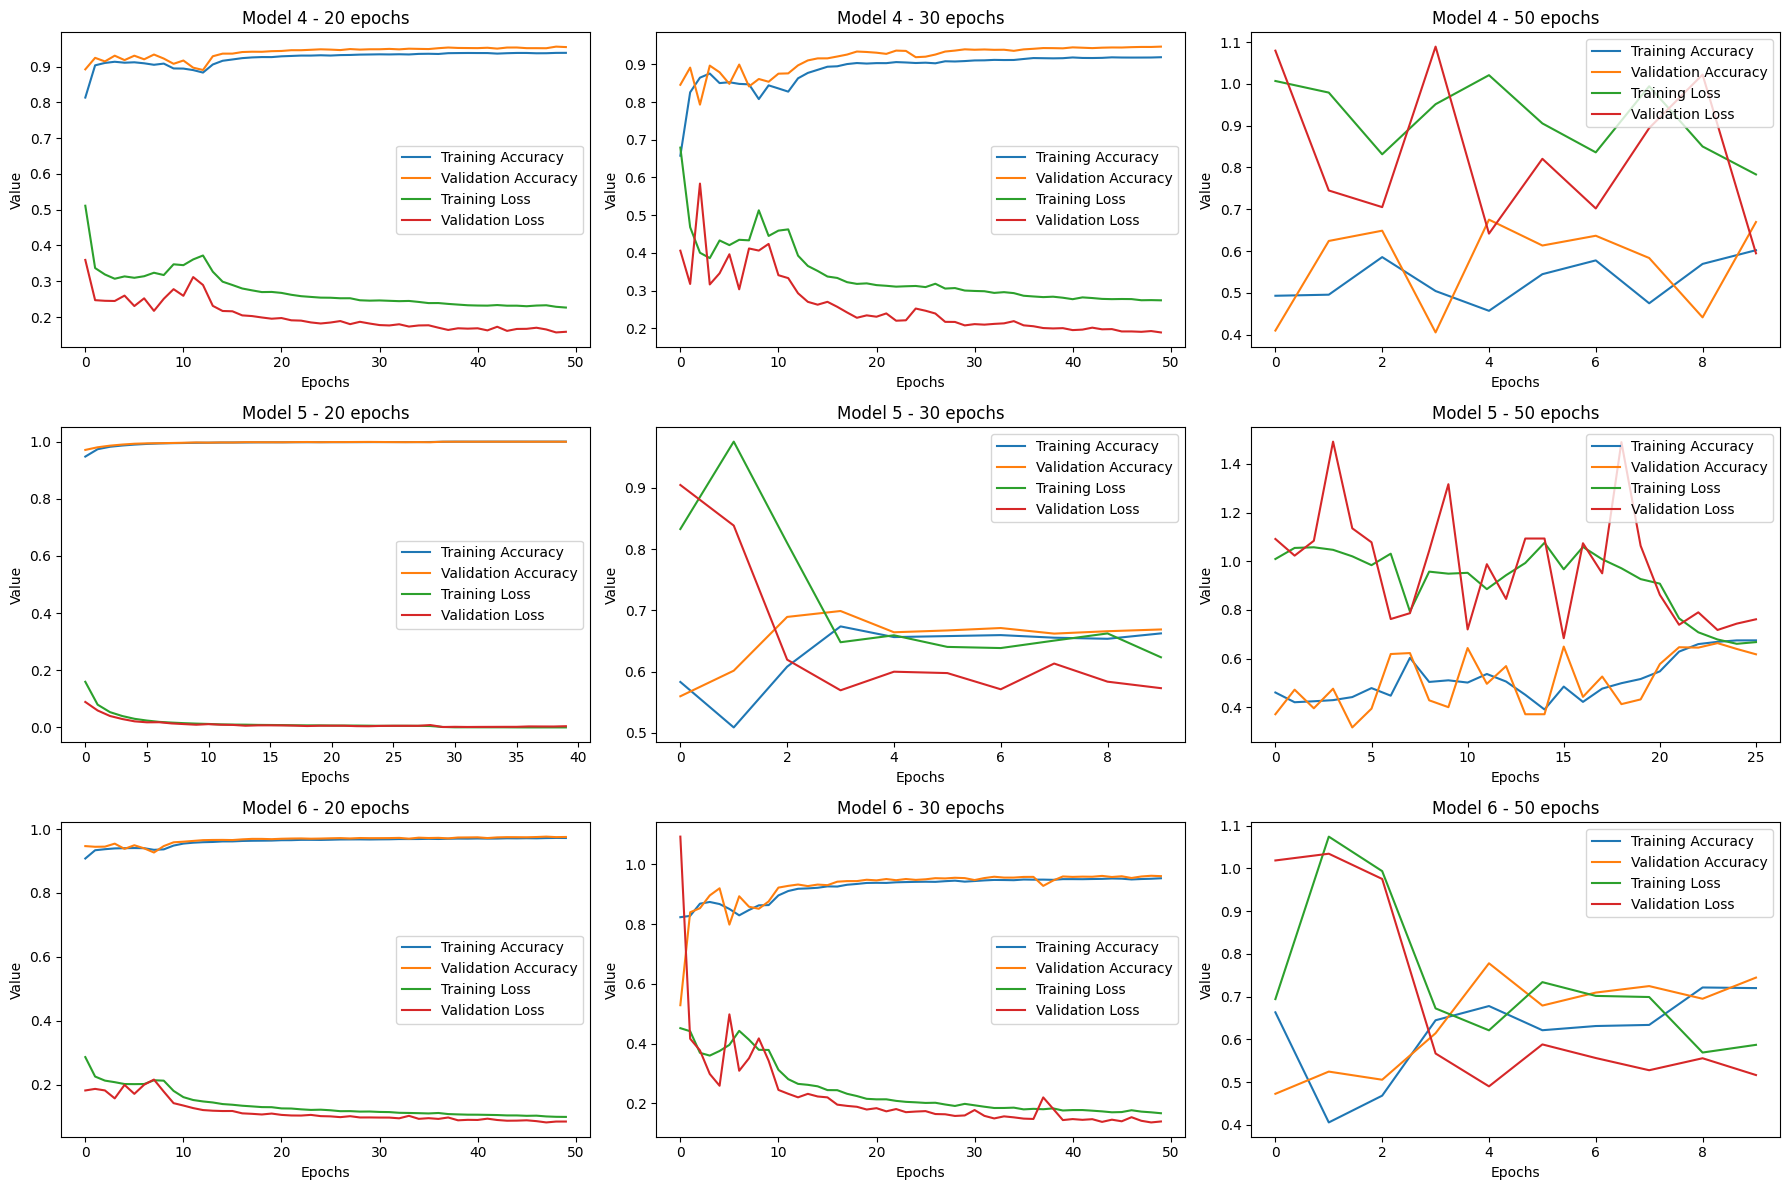

In [18]:
# Função para carregar os históricos
def load_history(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

# Carregar os históricos salvos
history_10_path = '../models/model_4/history_10.pkl'
history_11_path = '../models/model_4/history_11.pkl'
history_12_path = '../models/model_4/history_12.pkl'
history_13_path = '../models/model_5/history_13.pkl'
history_14_path = '../models/model_5/history_14.pkl'
history_15_path = '../models/model_5/history_15.pkl'
history_16_path = '../models/model_6/history_16.pkl'
history_17_path = '../models/model_6/history_17.pkl'
history_18_path = '../models/model_6/history_18.pkl'

# Carregar os históricos
history_10 = load_history(history_10_path)
history_11 = load_history(history_11_path)
history_12 = load_history(history_12_path)
history_13 = load_history(history_13_path)
history_14 = load_history(history_14_path)
history_15 = load_history(history_15_path)
history_16 = load_history(history_16_path)
history_17 = load_history(history_17_path)
history_18 = load_history(history_18_path)

# Lista de históricos para apresentar os gráficos
histories = [history_10, history_11, history_12, history_13, history_14, history_15, history_16, history_17, history_18]
labels = ['Model 4 - 20 epochs', 'Model 4 - 30 epochs', 'Model 4 - 50 epochs', 'Model 5 - 20 epochs', 'Model 5 - 30 epochs', 'Model 5 - 50 epochs', 'Model 6 - 20 epochs', 'Model 6 - 30 epochs', 'Model 6 - 50 epochs']

# Função para apresentar os gráficos dos múltiplos históricos
def plot_multiple_histories(histories, labels):
    plt.figure(figsize=(18, 12))

    for i, (history, label) in enumerate(zip(histories, labels)):
        plt.subplot(3, 3, i+1)

        plt.plot(history['accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        
        plt.title(label)
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_multiple_histories(histories, labels)
